In [44]:
from Data_Preprocessing import exp_var, indexed_df, hate_crime, region_grouped

import pandas as pd
import numpy as np
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
exp_var

['hate_crime',
 'hate_crime_combined',
 'hc_by_year',
 'region_grouped',
 'race_grouped',
 'indexed_df']

In [3]:
indexed_df.head()

,TOTAL_INCIDENTS
INCIDENT_MONTH,
1991-01-31,302
1991-02-28,287
1991-03-31,287
1991-04-30,309
1991-05-31,371


In [4]:
indexed_df_complete = indexed_df

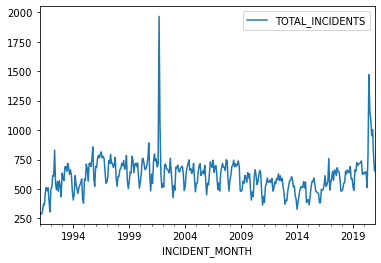

,TOTAL_INCIDENTS
INCIDENT_MONTH,
2001-09-30,1966
2001-10-31,1048
2020-06-30,1470
2020-07-31,1155
2020-08-31,1085
2020-10-31,1004


In [5]:
indexed_df.plot()
plt.show()

indexed_df[indexed_df['TOTAL_INCIDENTS'] > 1000]

### Remove outliers, months with incidents > 1000

In [6]:
replace_dict={1966:(indexed_df.loc['2000-09-30']['TOTAL_INCIDENTS'] + indexed_df.loc['2002-09-30']['TOTAL_INCIDENTS'])/2, 
              1048:(indexed_df.loc['2000-10-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2002-10-31']['TOTAL_INCIDENTS'])/2, 
              1470:(indexed_df.loc['2019-06-30']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-05-31']['TOTAL_INCIDENTS'])/2, 
              1155:(indexed_df.loc['2019-07-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-05-31']['TOTAL_INCIDENTS'])/2, 
              1085:(indexed_df.loc['2019-08-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-05-31']['TOTAL_INCIDENTS'])/2, 
              1004:(indexed_df.loc['2019-10-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-09-30']['TOTAL_INCIDENTS'])/2 
             }

print(replace_dict)

indexed_df.replace(to_replace=replace_dict, inplace=True)

{1966: 762.0, 1048: 772.0, 1470: 736.0, 1155: 742.5, 1085: 745.0, 1004: 845.0}


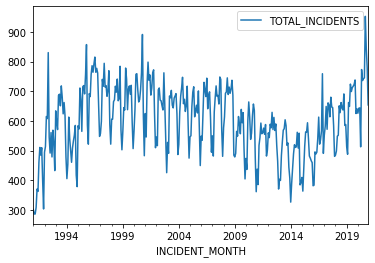

In [7]:
indexed_df.plot()
plt.show()

### Seasonality and stationarity

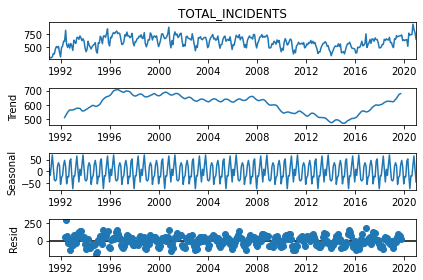

In [8]:
decompose_data = seasonal_decompose(indexed_df['TOTAL_INCIDENTS'], period=30)

decompose_plot = decompose_data.plot()

## trend is not consistent
##variation in residuals mostly accounted for in 2001 spike

<AxesSubplot:xlabel='INCIDENT_MONTH'>

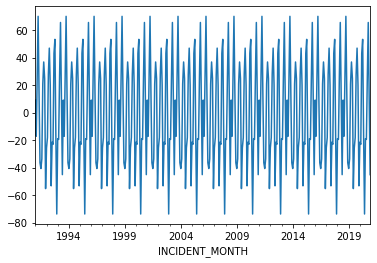

In [9]:
#inspect seasonality
seasonality = decompose_data.seasonal
seasonality.plot()

In [10]:
#Augmented Dickey Fuller test

dftest = adfuller(indexed_df.TOTAL_INCIDENTS, autolag = 'AIC')
print("ADF: ",dftest[0])
print("P-Value: ", dftest[1])
print("Num Of Lags: ", dftest[2])
print("Num Of Observations:", dftest[3])
print("Critical Values:")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    
## p-value is high, well above threshold of 0.05
##dataset is non-stationary

ADF:  -2.3563481920398264
P-Value:  0.15443758406898878
Num Of Lags:  14
Num Of Observations: 345
Critical Values:
	 1% :  -3.4494474563375737
	 5% :  -2.8699542285903887
	 10% :  -2.5712527305187987


<AxesSubplot:title={'center':'original'}, xlabel='INCIDENT_MONTH'>

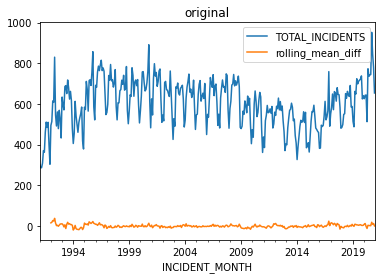

In [11]:
## use rolling mean as differencing method to impose stationarity

rolling_mean = indexed_df['TOTAL_INCIDENTS'].rolling(window = 12).mean()
indexed_df['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()

#plot original df and rolling mean difference together
indexed_df[['TOTAL_INCIDENTS', 'rolling_mean_diff']].plot(title='original')

In [12]:
#perform Augmented Dickey Fuller Test again on rolling_mean_diff

dftest = adfuller(indexed_df['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("ADF: ",dftest[0])
print("P-Value: ", dftest[1])
print("Num Of Lags: ", dftest[2])
print("Num Of Observations:", dftest[3])
print("Critical Values:")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    
## p value is much lower than 0.05 now; stationarity has been corrected with d=1

ADF:  -4.174192567360622
P-Value:  0.0007284062649401091
Num Of Lags:  14
Num Of Observations: 333
Critical Values:
	 1% :  -3.450141065277327
	 5% :  -2.870258846235788
	 10% :  -2.571415151457764


### ACF and PACF

In [13]:
indexed_df

,TOTAL_INCIDENTS,rolling_mean_diff
INCIDENT_MONTH,,
1991-01-31,302.0,NaN
1991-02-28,287.0,NaN
1991-03-31,287.0,NaN
1991-04-30,309.0,NaN
1991-05-31,371.0,NaN
...,...,...
2020-08-31,745.0,2.333333
2020-09-30,952.0,19.083333
2020-10-31,845.0,8.916667


In [14]:
#confidence interval
ci = 1.96/np.sqrt(len(indexed_df))
ci

# look into this, sigma?

0.10330107023216706

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


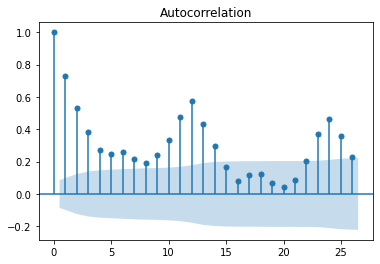

In [15]:
#ACF  (q value)
acf_array = acf(indexed_df['TOTAL_INCIDENTS'], fft=False)
plot_acf(indexed_df['TOTAL_INCIDENTS'], lags=26, alpha=ci)
plt.show()

#q=6

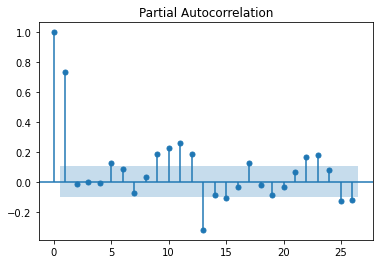

In [16]:
#PACF (p value)
plot_pacf(indexed_df['TOTAL_INCIDENTS'], lags = 26)
plt.show()

#p=3/4

In [17]:
## drop null values created by differencing

indexed_df.isnull().sum()
indexed_df.dropna(axis=1, inplace=True)

In [18]:
#ensure frequency is set for timeseries models
indexed_df = indexed_df.asfreq('M')

## ARIMA

In [19]:
#p = lags in the autoregresive model
p = 5
#d = differencing / integration order
d = 1
#q = moving average lags
q = 4

my_order=(p,d,q)

#Seasonal order
P = 5
D = 1
Q = 4
m = 12

my_seasonal_order = (P,D,Q,m)

In [20]:
model = ARIMA(indexed_df['TOTAL_INCIDENTS'], order=my_order)
results = model.fit()
results.summary()

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        TOTAL_INCIDENTS   No. Observations:                  360
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -2050.882
Date:                Mon, 07 Mar 2022   AIC                           4121.764
Time:                        17:47:44   BIC                           4160.597
Sample:                    01-31-1991   HQIC                          4137.207
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1760      0.109      1.613      0.107      -0.038       0.390
ar.L2          0.1439      0.074      1.933      0.053      -0.002       0.290
ar.L3          0.6909      0.058     11.865      0.000       0.577       0.805
ar.L4         -0.5998      0.059    -10.177      0.000      -0.715      -0.484
ar.L5         -0.1031      0.063     -1.638      0.101      -0.226       0.020
ma.L1         -0.4920      0.138     -3.562      0.000      -0.763      -0.221
ma.L2         -0.3380      0.049     -6.872      0.000      -0.434      -0.242
ma.L3         -0.7485      0.171     -4.389      0.000      -1.083      -0.414
ma.L4          0.7871      0.137      5.749      0.000       0.519       1.056
sigma2      5011.4739    772.781      6.485      0.000    3496.851    6526.097
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                11.72
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='INCIDENT_MONTH'>

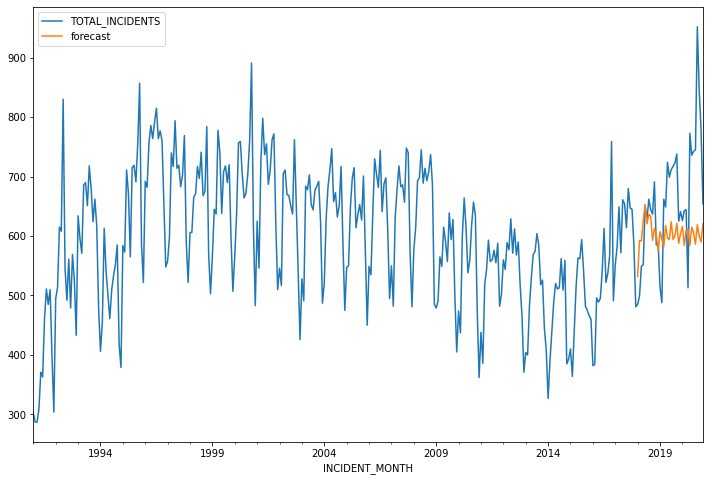

In [21]:
indexed_df['forecast'] = results.predict(start='2018-01', end='2020-12', dynamic=True)
indexed_df[['TOTAL_INCIDENTS', 'forecast']].plot(figsize=(12,8))

## SARIMAX

In [22]:
model = SARIMAX(indexed_df['TOTAL_INCIDENTS'], order=my_order, seasonal_order=(my_seasonal_order))
results = model.fit()
results.summary()

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_INCIDENTS   No. Observations:                  360
Model:             SARIMAX(5, 1, 4)x(5, 1, 4, 12)   Log Likelihood               -1894.531
Date:                            Mon, 07 Mar 2022   AIC                           3827.061
Time:                                    17:49:43   BIC                           3900.198
Sample:                                01-31-1991   HQIC                          3856.182
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0559      0.565      0.099      0.921      -1.051       1.162
ar.L2          0.2438      0.492      0.495      0.620      -0.721       1.209
ar.L3          0.8667      0.292      2.964      0.003       0.294       1.440
ar.L4         -0.2476      0.241     -1.028      0.304      -0.720       0.224
ar.L5         -0.0245      0.111     -0.222      0.825      -0.242       0.193
ma.L1         -0.5136      0.564     -0.910      0.363      -1.620       0.593
ma.L2         -0.4048      0.225     -1.798      0.072      -0.846       0.036
ma.L3         -0.7478      0.111     -6.715      0.000      -0.966      -0.530
ma.L4          0.6963      0.438      1.589      0.112      -0.162       1.555
ar.S.L12      -0.3775      0.336     -1.123      0.261      -1.036       0.281
ar.S.L24       0.0197      0.362      0.054      0.957      -0.690       0.729
ar.S.L36       0.7591      0.430      1.765      0.078      -0.084       1.602
ar.S.L48      -0.0971      0.172     -0.566      0.572      -0.434       0.239
ar.S.L60      -0.0240      0.129     -0.186      0.853      -0.278       0.230
ma.S.L12      -0.4660      4.302     -0.108      0.914      -8.897       7.965
ma.S.L24      -0.3330      0.644     -0.517      0.605      -1.595       0.929
ma.S.L36      -0.7390      8.445     -0.088      0.930     -17.290      15.812
ma.S.L48       0.7768      5.413      0.144      0.886      -9.832      11.386
sigma2      3361.0057   2.22e+04      0.152      0.880   -4.01e+04    4.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               278.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.19
Prob(H) (two-sided):                  0.29   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='INCIDENT_MONTH'>

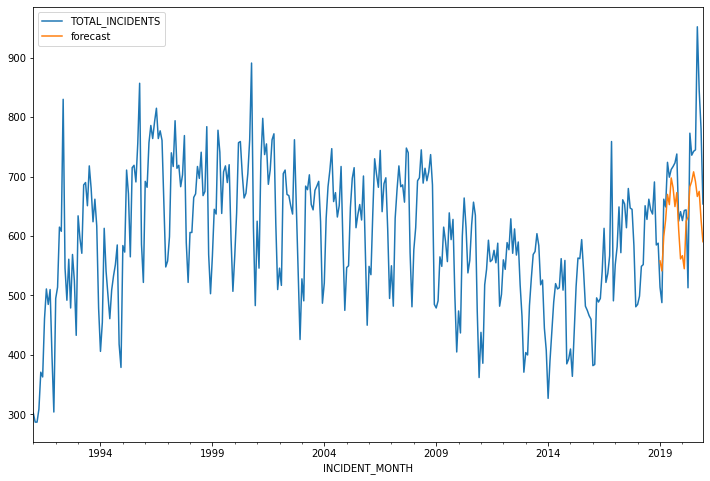

In [23]:
indexed_df['forecast']=results.predict(start='2019-01',end='2020-12',dynamic=True)
indexed_df[['TOTAL_INCIDENTS','forecast']].plot(figsize=(12,8))

## NEXT for Timeseries Analysis

Improve the model's performance with CV
explore timeseries analysis as supervised learning problem to predict future values

explore multivariate timeseries and look at total incidents by region, state, or population code

statistical test to determine outliers, 2xsigma

In [24]:
import itertools
import statsmodels.api as sm

In [30]:
p = d = q = range(0, 3)

In [31]:
pdq = list(itertools.product(p, d, q))

In [32]:
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [33]:
pdqs

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [34]:
ts = indexed_df[['TOTAL_INCIDENTS']]

In [35]:
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

In [36]:
results_df = sarimax_gridsearch(ts, pdq, pdqs, freq='M')
results_df

SARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =5632.579681139644
SARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =5060.7284005865995
SARIMAX (0, 0, 0) x (0, 0, 2, 12)12 : BIC Calculated =4649.074729594643
SARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =4129.436633407522
SARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =3896.023586674101
SARIMAX (0, 0, 0) x (0, 1, 2, 12)12 : BIC Calculated =3738.149957701243
SARIMAX (0, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =4274.315327047462
SARIMAX (0, 0, 0) x (0, 2, 1, 12)12 : BIC Calculated =3852.9006897130953
SARIMAX (0, 0, 0) x (0, 2, 2, 12)12 : BIC Calculated =3597.991453411939
SARIMAX (0, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =4149.994502877623
SARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =4099.261861694904
SARIMAX (0, 0, 0) x (1, 0, 2, 12)12 : BIC Calculated =3900.6250163105346
SARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =3920.866882869581
SARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : BIC Calculated =3898.77

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =4031.7957339432824


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 1) x (1, 0, 2, 12)12 : BIC Calculated =3795.146647069884
SARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =3826.0995967426597
SARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =3782.4265473053206
SARIMAX (0, 0, 1) x (1, 1, 2, 12)12 : BIC Calculated =3629.3963414143536
SARIMAX (0, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =3904.530157532956
SARIMAX (0, 0, 1) x (1, 2, 1, 12)12 : BIC Calculated =3715.773851536555
SARIMAX (0, 0, 1) x (1, 2, 2, 12)12 : BIC Calculated =3526.213617097222
SARIMAX (0, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =3832.030342739044
SARIMAX (0, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =3811.3051202745105


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 1) x (2, 0, 2, 12)12 : BIC Calculated =3801.8221793640455
SARIMAX (0, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =3649.490453457695
SARIMAX (0, 0, 1) x (2, 1, 1, 12)12 : BIC Calculated =3651.388632996275
SARIMAX (0, 0, 1) x (2, 1, 2, 12)12 : BIC Calculated =3629.3465946356214
SARIMAX (0, 0, 1) x (2, 2, 0, 12)12 : BIC Calculated =3637.493371117812
SARIMAX (0, 0, 1) x (2, 2, 1, 12)12 : BIC Calculated =3555.7836929269533
SARIMAX (0, 0, 1) x (2, 2, 2, 12)12 : BIC Calculated =3535.0715281760135
SARIMAX (0, 0, 2) x (0, 0, 0, 12)12 : BIC Calculated =4893.163036143201
SARIMAX (0, 0, 2) x (0, 0, 1, 12)12 : BIC Calculated =4500.600066824611
SARIMAX (0, 0, 2) x (0, 0, 2, 12)12 : BIC Calculated =4203.0625688148675
SARIMAX (0, 0, 2) x (0, 1, 0, 12)12 : BIC Calculated =3968.197621471961
SARIMAX (0, 0, 2) x (0, 1, 1, 12)12 : BIC Calculated =3750.210810433356
SARIMAX (0, 0, 2) x (0, 1, 2, 12)12 : BIC Calculated =3592.5115556559613
SARIMAX (0, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =4146

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 2) x (1, 0, 2, 12)12 : BIC Calculated =3781.1561684716276
SARIMAX (0, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =3811.107386234282
SARIMAX (0, 0, 2) x (1, 1, 1, 12)12 : BIC Calculated =3750.1502203732193
SARIMAX (0, 0, 2) x (1, 1, 2, 12)12 : BIC Calculated =3597.257809016125
SARIMAX (0, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =3891.7290612594556
SARIMAX (0, 0, 2) x (1, 2, 1, 12)12 : BIC Calculated =3687.1639832271067
SARIMAX (0, 0, 2) x (1, 2, 2, 12)12 : BIC Calculated =3497.4614344062493


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =3827.1933135603854


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =3802.6960685081126


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 2) x (2, 0, 2, 12)12 : BIC Calculated =3775.62968095334
SARIMAX (0, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =3630.269244869783
SARIMAX (0, 0, 2) x (2, 1, 1, 12)12 : BIC Calculated =3633.111461226123
SARIMAX (0, 0, 2) x (2, 1, 2, 12)12 : BIC Calculated =3593.9608021923236
SARIMAX (0, 0, 2) x (2, 2, 0, 12)12 : BIC Calculated =3623.8082217528763
SARIMAX (0, 0, 2) x (2, 2, 1, 12)12 : BIC Calculated =3540.4436549140846
SARIMAX (0, 0, 2) x (2, 2, 2, 12)12 : BIC Calculated =3501.0811443509233
SARIMAX (0, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =4178.296584830394
SARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =3975.4797246118515
SARIMAX (0, 1, 0) x (0, 0, 2, 12)12 : BIC Calculated =3793.806442375205
SARIMAX (0, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =4019.8701822926564
SARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : BIC Calculated =3731.5939805779403
SARIMAX (0, 1, 0) x (0, 1, 2, 12)12 : BIC Calculated =3587.2259027936516
SARIMAX (0, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =421

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 1, 1) x (2, 2, 2, 12)12 : BIC Calculated =3402.8635899436395
SARIMAX (0, 1, 2) x (0, 0, 0, 12)12 : BIC Calculated =4131.978475278132
SARIMAX (0, 1, 2) x (0, 0, 1, 12)12 : BIC Calculated =3917.7284560507032
SARIMAX (0, 1, 2) x (0, 0, 2, 12)12 : BIC Calculated =3730.425554568218
SARIMAX (0, 1, 2) x (0, 1, 0, 12)12 : BIC Calculated =3936.2949690926243
SARIMAX (0, 1, 2) x (0, 1, 1, 12)12 : BIC Calculated =3631.7519391539154
SARIMAX (0, 1, 2) x (0, 1, 2, 12)12 : BIC Calculated =3486.4294232835937
SARIMAX (0, 1, 2) x (0, 2, 0, 12)12 : BIC Calculated =4135.38778124457
SARIMAX (0, 1, 2) x (0, 2, 1, 12)12 : BIC Calculated =3654.8930281254325
SARIMAX (0, 1, 2) x (0, 2, 2, 12)12 : BIC Calculated =3391.062465988071
SARIMAX (0, 1, 2) x (1, 0, 0, 12)12 : BIC Calculated =3899.024045491503
SARIMAX (0, 1, 2) x (1, 0, 1, 12)12 : BIC Calculated =3789.8525152058182
SARIMAX (0, 1, 2) x (1, 0, 2, 12)12 : BIC Calculated =3655.001053805771
SARIMAX (0, 1, 2) x (1, 1, 0, 12)12 : BIC Calculated =3740

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 1) x (1, 2, 2, 12)12 : BIC Calculated =3492.6344056207604
SARIMAX (0, 2, 1) x (2, 0, 0, 12)12 : BIC Calculated =3777.69765966198
SARIMAX (0, 2, 1) x (2, 0, 1, 12)12 : BIC Calculated =3765.2398297189707
SARIMAX (0, 2, 1) x (2, 0, 2, 12)12 : BIC Calculated =3726.262339229048
SARIMAX (0, 2, 1) x (2, 1, 0, 12)12 : BIC Calculated =3639.333557879758
SARIMAX (0, 2, 1) x (2, 1, 1, 12)12 : BIC Calculated =3598.609150181585
SARIMAX (0, 2, 1) x (2, 1, 2, 12)12 : BIC Calculated =3570.5633655528422
SARIMAX (0, 2, 1) x (2, 2, 0, 12)12 : BIC Calculated =3675.93072815528
SARIMAX (0, 2, 1) x (2, 2, 1, 12)12 : BIC Calculated =3554.7032139684807
SARIMAX (0, 2, 1) x (2, 2, 2, 12)12 : BIC Calculated =3492.942334803322
SARIMAX (0, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =4153.818943569857
SARIMAX (0, 2, 2) x (0, 0, 1, 12)12 : BIC Calculated =3930.258078532624
SARIMAX (0, 2, 2) x (0, 0, 2, 12)12 : BIC Calculated =3744.707661221721
SARIMAX (0, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =3936.618

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (1, 2, 2, 12)12 : BIC Calculated =3395.795739559289
SARIMAX (0, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =3715.11564269938
SARIMAX (0, 2, 2) x (2, 0, 1, 12)12 : BIC Calculated =3692.689683107348


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (2, 0, 2, 12)12 : BIC Calculated =3646.8001877798874
SARIMAX (0, 2, 2) x (2, 1, 0, 12)12 : BIC Calculated =3549.616611956501
SARIMAX (0, 2, 2) x (2, 1, 1, 12)12 : BIC Calculated =3529.2829159437783


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (2, 1, 2, 12)12 : BIC Calculated =3484.567793913226
SARIMAX (0, 2, 2) x (2, 2, 0, 12)12 : BIC Calculated =3587.846152818311
SARIMAX (0, 2, 2) x (2, 2, 1, 12)12 : BIC Calculated =3469.683139792802


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (2, 2, 2, 12)12 : BIC Calculated =3479.5943349664253
SARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =4193.672270558043
SARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =3989.9124105079804
SARIMAX (1, 0, 0) x (0, 0, 2, 12)12 : BIC Calculated =3807.3048974495337
SARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =3962.5262785830214
SARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =3703.7006385379805
SARIMAX (1, 0, 0) x (0, 1, 2, 12)12 : BIC Calculated =3553.964286445963
SARIMAX (1, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =4151.428702180356
SARIMAX (1, 0, 0) x (0, 2, 1, 12)12 : BIC Calculated =3690.8929286051152
SARIMAX (1, 0, 0) x (0, 2, 2, 12)12 : BIC Calculated =3466.276110479967
SARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =3948.0936494902526
SARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =3859.764823219558
SARIMAX (1, 0, 0) x (1, 0, 2, 12)12 : BIC Calculated =3722.286489673152
SARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =375

SARIMAX (1, 1, 1) x (0, 1, 2, 12)12 : BIC Calculated =3500.0513478830667
SARIMAX (1, 1, 1) x (0, 2, 0, 12)12 : BIC Calculated =4147.662966776517
SARIMAX (1, 1, 1) x (0, 2, 1, 12)12 : BIC Calculated =3669.8131475043506
SARIMAX (1, 1, 1) x (0, 2, 2, 12)12 : BIC Calculated =3401.5148766259526
SARIMAX (1, 1, 1) x (1, 0, 0, 12)12 : BIC Calculated =3880.0240884670557
SARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : BIC Calculated =3800.606299376231
SARIMAX (1, 1, 1) x (1, 0, 2, 12)12 : BIC Calculated =3666.423215423647
SARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : BIC Calculated =3730.4151396223224
SARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : BIC Calculated =3647.699041985223
SARIMAX (1, 1, 1) x (1, 1, 2, 12)12 : BIC Calculated =3505.466278362782
SARIMAX (1, 1, 1) x (1, 2, 0, 12)12 : BIC Calculated =3823.9805601943335
SARIMAX (1, 1, 1) x (1, 2, 1, 12)12 : BIC Calculated =3625.3712322511174
SARIMAX (1, 1, 1) x (1, 2, 2, 12)12 : BIC Calculated =3403.971564830441
SARIMAX (1, 1, 1) x (2, 0, 0, 12)12 : BIC Calculated =370

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (1, 0, 2, 12)12 : BIC Calculated =3660.7185830849166
SARIMAX (1, 1, 2) x (1, 1, 0, 12)12 : BIC Calculated =3734.2387713503626
SARIMAX (1, 1, 2) x (1, 1, 1, 12)12 : BIC Calculated =3639.9585650425547
SARIMAX (1, 1, 2) x (1, 1, 2, 12)12 : BIC Calculated =3497.9299784410036
SARIMAX (1, 1, 2) x (1, 2, 0, 12)12 : BIC Calculated =3816.7630380309906
SARIMAX (1, 1, 2) x (1, 2, 1, 12)12 : BIC Calculated =3610.456494971996
SARIMAX (1, 1, 2) x (1, 2, 2, 12)12 : BIC Calculated =3396.876459801415
SARIMAX (1, 1, 2) x (2, 0, 0, 12)12 : BIC Calculated =3702.8238616094322


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 0, 1, 12)12 : BIC Calculated =3683.0147610535378


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 0, 2, 12)12 : BIC Calculated =3652.7486474309017
SARIMAX (1, 1, 2) x (2, 1, 0, 12)12 : BIC Calculated =3543.345241800449


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 1, 1, 12)12 : BIC Calculated =3521.0178471208505
SARIMAX (1, 1, 2) x (2, 1, 2, 12)12 : BIC Calculated =3498.228547510869
SARIMAX (1, 1, 2) x (2, 2, 0, 12)12 : BIC Calculated =3571.8593726264166
SARIMAX (1, 1, 2) x (2, 2, 1, 12)12 : BIC Calculated =3459.4221362973826


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 2, 2, 12)12 : BIC Calculated =3403.8436559876877
SARIMAX (1, 2, 0) x (0, 0, 0, 12)12 : BIC Calculated =4355.922533011486
SARIMAX (1, 2, 0) x (0, 0, 1, 12)12 : BIC Calculated =4153.71862185509
SARIMAX (1, 2, 0) x (0, 0, 2, 12)12 : BIC Calculated =3978.2956428410075
SARIMAX (1, 2, 0) x (0, 1, 0, 12)12 : BIC Calculated =4213.419313485662
SARIMAX (1, 2, 0) x (0, 1, 1, 12)12 : BIC Calculated =3925.585982862558
SARIMAX (1, 2, 0) x (0, 1, 2, 12)12 : BIC Calculated =3771.5891036569856
SARIMAX (1, 2, 0) x (0, 2, 0, 12)12 : BIC Calculated =4402.026137545116
SARIMAX (1, 2, 0) x (0, 2, 1, 12)12 : BIC Calculated =3925.945322586078
SARIMAX (1, 2, 0) x (0, 2, 2, 12)12 : BIC Calculated =3668.345465900076
SARIMAX (1, 2, 0) x (1, 0, 0, 12)12 : BIC Calculated =4123.083557545899
SARIMAX (1, 2, 0) x (1, 0, 1, 12)12 : BIC Calculated =4070.743571609715
SARIMAX (1, 2, 0) x (1, 0, 2, 12)12 : BIC Calculated =3935.2690255906696
SARIMAX (1, 2, 0) x (1, 1, 0, 12)12 : BIC Calculated =4002.54

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 0) x (2, 2, 2, 12)12 : BIC Calculated =3666.878915080194
SARIMAX (1, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =4167.258489440772
SARIMAX (1, 2, 1) x (0, 0, 1, 12)12 : BIC Calculated =3953.291063340718
SARIMAX (1, 2, 1) x (0, 0, 2, 12)12 : BIC Calculated =3768.9791788796915
SARIMAX (1, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =3975.760504581037
SARIMAX (1, 2, 1) x (0, 1, 1, 12)12 : BIC Calculated =3681.5664949461816
SARIMAX (1, 2, 1) x (0, 1, 2, 12)12 : BIC Calculated =3537.123608502427
SARIMAX (1, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =4171.120421509305
SARIMAX (1, 2, 1) x (0, 2, 1, 12)12 : BIC Calculated =3693.4496486555054
SARIMAX (1, 2, 1) x (0, 2, 2, 12)12 : BIC Calculated =3443.8468747954066
SARIMAX (1, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =3915.907488315239
SARIMAX (1, 2, 1) x (1, 0, 1, 12)12 : BIC Calculated =3836.8904705785685


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 1) x (1, 0, 2, 12)12 : BIC Calculated =3703.5827669963137
SARIMAX (1, 2, 1) x (1, 1, 0, 12)12 : BIC Calculated =3766.746532300303
SARIMAX (1, 2, 1) x (1, 1, 1, 12)12 : BIC Calculated =3687.313743367023
SARIMAX (1, 2, 1) x (1, 1, 2, 12)12 : BIC Calculated =3541.1913190819337
SARIMAX (1, 2, 1) x (1, 2, 0, 12)12 : BIC Calculated =3855.3327671741304
SARIMAX (1, 2, 1) x (1, 2, 1, 12)12 : BIC Calculated =3656.4843560052063


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 1) x (1, 2, 2, 12)12 : BIC Calculated =3449.4307493874576
SARIMAX (1, 2, 1) x (2, 0, 0, 12)12 : BIC Calculated =3735.5490923151597


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 1) x (2, 0, 1, 12)12 : BIC Calculated =3718.935267435042
SARIMAX (1, 2, 1) x (2, 0, 2, 12)12 : BIC Calculated =3691.3225248905123
SARIMAX (1, 2, 1) x (2, 1, 0, 12)12 : BIC Calculated =3577.3172522246878
SARIMAX (1, 2, 1) x (2, 1, 1, 12)12 : BIC Calculated =3547.9763629159847
SARIMAX (1, 2, 1) x (2, 1, 2, 12)12 : BIC Calculated =3540.978516777624
SARIMAX (1, 2, 1) x (2, 2, 0, 12)12 : BIC Calculated =3606.7321764007997
SARIMAX (1, 2, 1) x (2, 2, 1, 12)12 : BIC Calculated =3495.675320520143


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 1) x (2, 2, 2, 12)12 : BIC Calculated =3453.394221906414
SARIMAX (1, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =4124.744147582146


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (0, 0, 1, 12)12 : BIC Calculated =3898.8216080364195


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (0, 0, 2, 12)12 : BIC Calculated =3757.242916386336
SARIMAX (1, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =3938.007641098451
SARIMAX (1, 2, 2) x (0, 1, 1, 12)12 : BIC Calculated =3636.375285544926
SARIMAX (1, 2, 2) x (0, 1, 2, 12)12 : BIC Calculated =3485.3402655759332
SARIMAX (1, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =4141.097425768747


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (0, 2, 1, 12)12 : BIC Calculated =3656.92149645842
SARIMAX (1, 2, 2) x (0, 2, 2, 12)12 : BIC Calculated =3400.013803408229


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =3886.5967598659167


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (1, 0, 1, 12)12 : BIC Calculated =3793.0044703498374


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (1, 0, 2, 12)12 : BIC Calculated =3660.7171560457473
SARIMAX (1, 2, 2) x (1, 1, 0, 12)12 : BIC Calculated =3732.7030368837677


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (1, 1, 1, 12)12 : BIC Calculated =3637.7321312559134


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (1, 1, 2, 12)12 : BIC Calculated =3491.3619085303208
SARIMAX (1, 2, 2) x (1, 2, 0, 12)12 : BIC Calculated =3822.892497763644


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (1, 2, 1, 12)12 : BIC Calculated =3614.225848368758


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (1, 2, 2, 12)12 : BIC Calculated =3402.234130035471


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =3706.628396108348


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 0, 1, 12)12 : BIC Calculated =3733.2040971799793


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 0, 2, 12)12 : BIC Calculated =3742.217062524382


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 1, 0, 12)12 : BIC Calculated =3539.783750408764


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 1, 1, 12)12 : BIC Calculated =3528.206673796566


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 1, 2, 12)12 : BIC Calculated =3488.4133170833443


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 2, 0, 12)12 : BIC Calculated =3581.0708434757516


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 2, 1, 12)12 : BIC Calculated =3461.9411722320774


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 2, 2, 12)12 : BIC Calculated =3441.4455841870963
SARIMAX (2, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =4182.893911029078
SARIMAX (2, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =3980.377597443378
SARIMAX (2, 0, 0) x (0, 0, 2, 12)12 : BIC Calculated =3796.5234005866437
SARIMAX (2, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =3945.9001107645804
SARIMAX (2, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =3684.6188028996635
SARIMAX (2, 0, 0) x (0, 1, 2, 12)12 : BIC Calculated =3541.556399071397
SARIMAX (2, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =4139.699623998708
SARIMAX (2, 0, 0) x (0, 2, 1, 12)12 : BIC Calculated =3685.1541207038904
SARIMAX (2, 0, 0) x (0, 2, 2, 12)12 : BIC Calculated =3444.69182644353
SARIMAX (2, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =3917.1878738037867
SARIMAX (2, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =3830.8749657163157
SARIMAX (2, 0, 0) x (1, 0, 2, 12)12 : BIC Calculated =3710.155962923313
SARIMAX (2, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =3731

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 0) x (2, 2, 2, 12)12 : BIC Calculated =3439.32901367722


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =4153.079229373032


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =3947.884824852682


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (0, 0, 2, 12)12 : BIC Calculated =3787.016372967984
SARIMAX (2, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =3942.7707884834313
SARIMAX (2, 0, 1) x (0, 1, 1, 12)12 : BIC Calculated =3652.595793671546
SARIMAX (2, 0, 1) x (0, 1, 2, 12)12 : BIC Calculated =3513.042826559487
SARIMAX (2, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =4140.552349066685
SARIMAX (2, 0, 1) x (0, 2, 1, 12)12 : BIC Calculated =3667.3425469029266


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (0, 2, 2, 12)12 : BIC Calculated =3411.4576252810843


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =3885.8639203085663


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =3840.1129269165313


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (1, 0, 2, 12)12 : BIC Calculated =3682.923441356469
SARIMAX (2, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =3719.9583377433023
SARIMAX (2, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =3658.348729196935


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (1, 1, 2, 12)12 : BIC Calculated =3516.19263849922
SARIMAX (2, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =3807.447383359033
SARIMAX (2, 0, 1) x (1, 2, 1, 12)12 : BIC Calculated =3625.589018830687


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (1, 2, 2, 12)12 : BIC Calculated =3421.0304588438435


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =3745.529105120031


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =3757.25814325638


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 0, 2, 12)12 : BIC Calculated =3697.379855610071
SARIMAX (2, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =3538.5828838497323


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 1, 1, 12)12 : BIC Calculated =3508.5935335393638


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 1, 2, 12)12 : BIC Calculated =3513.809227644055
SARIMAX (2, 0, 1) x (2, 2, 0, 12)12 : BIC Calculated =3568.127593727518


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 2, 1, 12)12 : BIC Calculated =3450.7562669628674


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 2, 2, 12)12 : BIC Calculated =3480.558333142739
SARIMAX (2, 0, 2) x (0, 0, 0, 12)12 : BIC Calculated =4137.530215674339


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (0, 0, 1, 12)12 : BIC Calculated =3940.455022552658
SARIMAX (2, 0, 2) x (0, 0, 2, 12)12 : BIC Calculated =3777.95935123631
SARIMAX (2, 0, 2) x (0, 1, 0, 12)12 : BIC Calculated =3931.599995210361


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (0, 1, 1, 12)12 : BIC Calculated =3642.9975764272394
SARIMAX (2, 0, 2) x (0, 1, 2, 12)12 : BIC Calculated =3505.393568454336
SARIMAX (2, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =4111.291934707221
SARIMAX (2, 0, 2) x (0, 2, 1, 12)12 : BIC Calculated =3657.270637857851


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (0, 2, 2, 12)12 : BIC Calculated =3404.4705195156344
SARIMAX (2, 0, 2) x (1, 0, 0, 12)12 : BIC Calculated =3918.935865101666


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (1, 0, 1, 12)12 : BIC Calculated =3861.4418250617223


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (1, 0, 2, 12)12 : BIC Calculated =3728.1608287917434
SARIMAX (2, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =3724.0194856437074


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (1, 1, 1, 12)12 : BIC Calculated =3653.3958079278173
SARIMAX (2, 0, 2) x (1, 1, 2, 12)12 : BIC Calculated =3510.330155661351
SARIMAX (2, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =3803.5504317953632
SARIMAX (2, 0, 2) x (1, 2, 1, 12)12 : BIC Calculated =3618.4016922380733


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (1, 2, 2, 12)12 : BIC Calculated =3409.4082429586865
SARIMAX (2, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =3760.3162319507815


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =3756.6435938394234


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 0, 2, 12)12 : BIC Calculated =3733.4041911866684
SARIMAX (2, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =3543.4432092774473


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 1, 1, 12)12 : BIC Calculated =3517.7965481758824


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 1, 2, 12)12 : BIC Calculated =3509.581240517177


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 2, 0, 12)12 : BIC Calculated =3563.398757594434
SARIMAX (2, 0, 2) x (2, 2, 1, 12)12 : BIC Calculated =3454.623337860409


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 2, 2, 12)12 : BIC Calculated =3411.567192074234
SARIMAX (2, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =4167.2121685005295
SARIMAX (2, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =3961.848614565454
SARIMAX (2, 1, 0) x (0, 0, 2, 12)12 : BIC Calculated =3768.506046629314
SARIMAX (2, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =3953.6842345233676
SARIMAX (2, 1, 0) x (0, 1, 1, 12)12 : BIC Calculated =3661.220966536962
SARIMAX (2, 1, 0) x (0, 1, 2, 12)12 : BIC Calculated =3519.2410404662787
SARIMAX (2, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =4151.451721326126
SARIMAX (2, 1, 0) x (0, 2, 1, 12)12 : BIC Calculated =3686.181994498151
SARIMAX (2, 1, 0) x (0, 2, 2, 12)12 : BIC Calculated =3421.3347898537704
SARIMAX (2, 1, 0) x (1, 0, 0, 12)12 : BIC Calculated =3888.964195675673
SARIMAX (2, 1, 0) x (1, 0, 1, 12)12 : BIC Calculated =3807.6274092818308
SARIMAX (2, 1, 0) x (1, 0, 2, 12)12 : BIC Calculated =3689.2301004217375
SARIMAX (2, 1, 0) x (1, 1, 0, 12)12 : BIC Calculated =3720

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (1, 2, 2, 12)12 : BIC Calculated =3407.0581570926834
SARIMAX (2, 1, 1) x (2, 0, 0, 12)12 : BIC Calculated =3697.430479856972
SARIMAX (2, 1, 1) x (2, 0, 1, 12)12 : BIC Calculated =3670.9696590920926


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (2, 0, 2, 12)12 : BIC Calculated =3663.6613305012647
SARIMAX (2, 1, 1) x (2, 1, 0, 12)12 : BIC Calculated =3528.991388858557
SARIMAX (2, 1, 1) x (2, 1, 1, 12)12 : BIC Calculated =3499.5464704665674
SARIMAX (2, 1, 1) x (2, 1, 2, 12)12 : BIC Calculated =3504.0267895443703
SARIMAX (2, 1, 1) x (2, 2, 0, 12)12 : BIC Calculated =3567.83227535913
SARIMAX (2, 1, 1) x (2, 2, 1, 12)12 : BIC Calculated =3451.312702977218


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (2, 2, 2, 12)12 : BIC Calculated =3418.1995986523866
SARIMAX (2, 1, 2) x (0, 0, 0, 12)12 : BIC Calculated =4108.761566047168
SARIMAX (2, 1, 2) x (0, 0, 1, 12)12 : BIC Calculated =3905.292234176292
SARIMAX (2, 1, 2) x (0, 0, 2, 12)12 : BIC Calculated =3730.5477638997945
SARIMAX (2, 1, 2) x (0, 1, 0, 12)12 : BIC Calculated =3947.5093161867676
SARIMAX (2, 1, 2) x (0, 1, 1, 12)12 : BIC Calculated =3638.3644033569503
SARIMAX (2, 1, 2) x (0, 1, 2, 12)12 : BIC Calculated =3497.9825904705876
SARIMAX (2, 1, 2) x (0, 2, 0, 12)12 : BIC Calculated =4146.386821835764


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (0, 2, 1, 12)12 : BIC Calculated =3671.5174570830472


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (0, 2, 2, 12)12 : BIC Calculated =3403.5306443256295


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (1, 0, 0, 12)12 : BIC Calculated =3874.7814543237578


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (1, 0, 1, 12)12 : BIC Calculated =3801.476603822145


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (1, 0, 2, 12)12 : BIC Calculated =3666.4017845348317
SARIMAX (2, 1, 2) x (1, 1, 0, 12)12 : BIC Calculated =3724.828156344358
SARIMAX (2, 1, 2) x (1, 1, 1, 12)12 : BIC Calculated =3644.167475412144


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (1, 1, 2, 12)12 : BIC Calculated =3502.6314051602403
SARIMAX (2, 1, 2) x (1, 2, 0, 12)12 : BIC Calculated =3803.2697216472225
SARIMAX (2, 1, 2) x (1, 2, 1, 12)12 : BIC Calculated =3615.8092853844355


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (1, 2, 2, 12)12 : BIC Calculated =3409.6972996274662
SARIMAX (2, 1, 2) x (2, 0, 0, 12)12 : BIC Calculated =3697.2187559689123


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (2, 0, 1, 12)12 : BIC Calculated =3679.4651693085048


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (2, 0, 2, 12)12 : BIC Calculated =3659.9681955890687
SARIMAX (2, 1, 2) x (2, 1, 0, 12)12 : BIC Calculated =3534.5006298028247
SARIMAX (2, 1, 2) x (2, 1, 1, 12)12 : BIC Calculated =3508.1540328569


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (2, 1, 2, 12)12 : BIC Calculated =3501.07253468569
SARIMAX (2, 1, 2) x (2, 2, 0, 12)12 : BIC Calculated =3574.2290335041052
SARIMAX (2, 1, 2) x (2, 2, 1, 12)12 : BIC Calculated =3454.4421121101236


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (2, 2, 2, 12)12 : BIC Calculated =3406.79715175903
SARIMAX (2, 2, 0) x (0, 0, 0, 12)12 : BIC Calculated =4301.123258487386
SARIMAX (2, 2, 0) x (0, 0, 1, 12)12 : BIC Calculated =4100.1482147126035
SARIMAX (2, 2, 0) x (0, 0, 2, 12)12 : BIC Calculated =3914.6072188526273
SARIMAX (2, 2, 0) x (0, 1, 0, 12)12 : BIC Calculated =4112.264284607137
SARIMAX (2, 2, 0) x (0, 1, 1, 12)12 : BIC Calculated =3826.667400566332
SARIMAX (2, 2, 0) x (0, 1, 2, 12)12 : BIC Calculated =3680.653880457996
SARIMAX (2, 2, 0) x (0, 2, 0, 12)12 : BIC Calculated =4302.498418063318
SARIMAX (2, 2, 0) x (0, 2, 1, 12)12 : BIC Calculated =3840.1797392342696
SARIMAX (2, 2, 0) x (0, 2, 2, 12)12 : BIC Calculated =3582.7395808328265
SARIMAX (2, 2, 0) x (1, 0, 0, 12)12 : BIC Calculated =4038.9794168849576
SARIMAX (2, 2, 0) x (1, 0, 1, 12)12 : BIC Calculated =3968.593678105285
SARIMAX (2, 2, 0) x (1, 0, 2, 12)12 : BIC Calculated =3845.4727183420855
SARIMAX (2, 2, 0) x (1, 1, 0, 12)12 : BIC Calculated =3887.

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 0) x (2, 0, 1, 12)12 : BIC Calculated =3834.9794339283367
SARIMAX (2, 2, 0) x (2, 0, 2, 12)12 : BIC Calculated =3825.7019892815165
SARIMAX (2, 2, 0) x (2, 1, 0, 12)12 : BIC Calculated =3696.4702745500485
SARIMAX (2, 2, 0) x (2, 1, 1, 12)12 : BIC Calculated =3668.943361173919
SARIMAX (2, 2, 0) x (2, 1, 2, 12)12 : BIC Calculated =3672.576362799353
SARIMAX (2, 2, 0) x (2, 2, 0, 12)12 : BIC Calculated =3725.6711648727305
SARIMAX (2, 2, 0) x (2, 2, 1, 12)12 : BIC Calculated =3609.4730646488306
SARIMAX (2, 2, 0) x (2, 2, 2, 12)12 : BIC Calculated =3578.714925056186
SARIMAX (2, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =4167.825830258295
SARIMAX (2, 2, 1) x (0, 0, 1, 12)12 : BIC Calculated =3949.9459226965932
SARIMAX (2, 2, 1) x (0, 0, 2, 12)12 : BIC Calculated =3756.130829654203
SARIMAX (2, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =3955.659582631688
SARIMAX (2, 2, 1) x (0, 1, 1, 12)12 : BIC Calculated =3649.70976026516
SARIMAX (2, 2, 1) x (0, 1, 2, 12)12 : BIC Calculated =3511.

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 1) x (2, 2, 2, 12)12 : BIC Calculated =3424.714433337874
SARIMAX (2, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =4111.127967363726


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (0, 0, 1, 12)12 : BIC Calculated =3908.705379789599


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (0, 0, 2, 12)12 : BIC Calculated =3793.0340383597136
SARIMAX (2, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =3942.9284769353917


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (0, 1, 1, 12)12 : BIC Calculated =3637.629394319486


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (0, 1, 2, 12)12 : BIC Calculated =3490.3443365669514
SARIMAX (2, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =4138.754320528594
SARIMAX (2, 2, 2) x (0, 2, 1, 12)12 : BIC Calculated =3659.4486801158396


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (0, 2, 2, 12)12 : BIC Calculated =3401.5757823390186


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =3878.646389021609


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (1, 0, 1, 12)12 : BIC Calculated =3800.4606418690196


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (1, 0, 2, 12)12 : BIC Calculated =3710.2322006333993
SARIMAX (2, 2, 2) x (1, 1, 0, 12)12 : BIC Calculated =3719.77888270751


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (1, 1, 1, 12)12 : BIC Calculated =3638.838041843338


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (1, 1, 2, 12)12 : BIC Calculated =3527.7283719911716
SARIMAX (2, 2, 2) x (1, 2, 0, 12)12 : BIC Calculated =3805.7374655692556
SARIMAX (2, 2, 2) x (1, 2, 1, 12)12 : BIC Calculated =3616.39032185756


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (1, 2, 2, 12)12 : BIC Calculated =3410.293628354042
SARIMAX (2, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =3697.1722081714124


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 0, 1, 12)12 : BIC Calculated =3706.967410766908


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 0, 2, 12)12 : BIC Calculated =3667.9927682488797


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 1, 0, 12)12 : BIC Calculated =3532.1398105414128


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 1, 1, 12)12 : BIC Calculated =3505.6667839885936


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 1, 2, 12)12 : BIC Calculated =3556.112973926399


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 2, 0, 12)12 : BIC Calculated =3601.913338328349


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 2, 1, 12)12 : BIC Calculated =3461.0720164666923


C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 2, 2, 12)12 : BIC Calculated =3461.206040609655


,pdq,pdqs,bic
143,"(0, 1, 2)","(0, 2, 2, 12)",3391.062466
386,"(1, 1, 2)","(0, 2, 2, 12)",3391.265622
152,"(0, 1, 2)","(1, 2, 2, 12)",3392.649079
224,"(0, 2, 2)","(0, 2, 2, 12)",3393.988898
161,"(0, 1, 2)","(2, 2, 2, 12)",3395.417232


In [ ]:
SARIMAX (0, 0, 2) x (0, 2, 2, 12)12 : BIC Calculated =3491.8891444072333
    
SARIMAX (0, 1, 1) x (1, 2, 2, 12)12 : BIC Calculated =3399.3717032038985
        
SARIMAX (0, 1, 2) x (0, 2, 2, 12)12 : BIC Calculated =3391.062465988071

In [ ]:
results_df.to_csv

In [39]:
results_df[results_df['bic'].min()]

KeyError: 3391.062465988071

### Supervised Learning with Timeseries

In [ ]:
#create lag features t, t-1, t-2, etc
#can compute more advanced features like rolling mean pd rolling() 
#or expanding windows pd expanding()
#use ridge regression to select most impactful lag features

#walk forward validation with sklearn TimeSeriesSplit()

#evaluation with MAE, MSE, RMSE

In [42]:
hate_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219577 entries, 0 to 219576
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   DATA_YEAR              219577 non-null  int64         
 1   STATE_ABBR             219577 non-null  object        
 2   REGION_NAME            219577 non-null  object        
 3   POPULATION_GROUP_CODE  219577 non-null  object        
 4   INCIDENT_DATE          219577 non-null  datetime64[ns]
 5   TOTAL_OFFENDER_COUNT   219577 non-null  int64         
 6   OFFENDER_RACE          219577 non-null  object        
 7   VICTIM_COUNT           219577 non-null  int64         
 8   OFFENSE_NAME           219577 non-null  object        
 9   LOCATION_NAME          219577 non-null  object        
 10  BIAS_DESC              219577 non-null  object        
 11  VICTIM_TYPES           219577 non-null  object        
 12  TOTAL_INCIDENTS        219577 non-null  int6

In [ ]:
regions = hate_crime

In [45]:
region_grouped

,REGION_NAME,DATA_YEAR,INCIDENT_COUNT
0,Midwest,1991,733
1,Midwest,1992,779
2,Midwest,1993,1565
3,Midwest,1994,1127
4,Midwest,1995,1356
...,...,...,...
121,West,2016,1954
122,West,2017,2226
123,West,2018,2195
124,West,2019,2391
